<a href="https://colab.research.google.com/github/leoquiroa/TimeSeries/blob/master/Prophet/By_Week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# essentials
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# time series algorithm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics

import datetime
import holidays
from sklearn import preprocessing

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()

# Methods

In [0]:
def read_raw_csv(url,nrows):
  df_doc = pd.read_csv(
      url, 
      nrows=nrows,
      names = ['ds','cat','y'], 
      parse_dates = True )
  df_doc['ds'] = pd.to_datetime(df_doc['ds'])
  return df_doc

In [0]:
def filter_by(df_doc, name_doc):
  return df_doc[df_doc['cat'] == name_doc][['ds','y']].reset_index(drop=True)

In [0]:
def split_train_test(df_filter, date_start_test):
  split_point = df_filter[df_filter['ds']==date_start_test].index[0]
  train = df_filter[:split_point]
  test = df_filter[split_point:]
  return [train, test]

In [0]:
def compare_dates(date_begin, date_end, forecast, data):
  yhat = forecast[(forecast['ds'] >= date_begin) & (forecast['ds'] <= date_end)][['ds','yhat']]
  yreal = data[(data['ds'] >= date_begin) & (data['ds'] <= date_end)]
  merged_inner = pd.merge(left=yreal,right=yhat, left_on='ds', right_on='ds')
  return merged_inner

In [0]:
def get_df_holidays(year_list):
  us_holidays = holidays.UnitedStates()
  mylist = []
  for date, name in sorted(holidays.US(years=year_list).items()):
    mylist.append((name,date,0,0))
  df_holidays = pd.DataFrame(mylist, columns = ['holiday' , 'ds', 'lower_window' , 'upper_window'])

In [0]:
def turn_week_to_date(yyyy,w):
    d = str(yyyy) + "-U" + str(w)
    r = datetime.datetime.strptime(d + '-0', "%Y-U%U-%w")
    return str(r.year) + '-' + str(r.month) + '-' + str(r.day)

# Data preparation

In [0]:
url = 'https://raw.githubusercontent.com/leoquiroa/TimeSeries/master/Data/daily_revenue_doctor.csv'
df_doc = read_raw_csv(url, 4167)
df_filter = filter_by(df_doc, 'Robert Caputo')
df_filter = df_filter.set_index(pd.DatetimeIndex(df_filter['ds']))

In [0]:
revenue_x_w = df_filter.groupby([df_filter.index.year, df_filter.index.week]).sum()
revenue_x_w['info'] = revenue_x_w.index
revenue_x_w = revenue_x_w.reset_index(drop=True)
revenue_x_w['ds'] = revenue_x_w['info'].apply(lambda x : turn_week_to_date(x[0],x[1]))
revenue_x_w = revenue_x_w.drop('info', axis=1)
revenue_x_w = revenue_x_w[['ds', 'y']]
revenue_x_w['ds'] = pd.to_datetime(revenue_x_w['ds'])

In [0]:
revenue_x_w = revenue_x_w[revenue_x_w['ds']<='2019-11-24']

In [0]:
[train,test] = split_train_test(revenue_x_w, '2019-09-01')

In [12]:
print(train.shape)
print(test.shape)
test

(184, 2)
(13, 2)


,ds,y
184,2019-09-01,24632.04
185,2019-09-08,25638.09
186,2019-09-15,26020.79
187,2019-09-22,24193.45
188,2019-09-29,21979.14
189,2019-10-06,24833.23
190,2019-10-13,29091.20
191,2019-10-20,54784.86
192,2019-10-27,32441.04
193,2019-11-03,38829.11


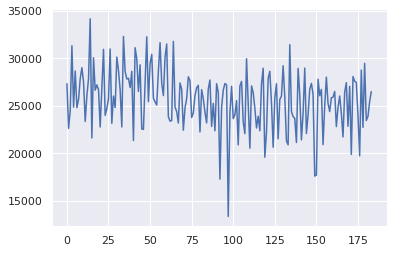

In [13]:
plt.plot(train['y'])

In [14]:
print(revenue_x_w['y'].min())
print(revenue_x_w['y'].mean())
print(revenue_x_w['y'].median())
print(revenue_x_w['y'].std())
print(revenue_x_w['y'].max())

13341.720000000001
26008.495025380722
25897.19
4056.8962559525553
54784.86000000001


# Simple Model

In [15]:
m = Prophet(weekly_seasonality=True,daily_seasonality=False)
m.fit(train)
future = m.make_future_dataframe(periods=13, freq='w')
forecast = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


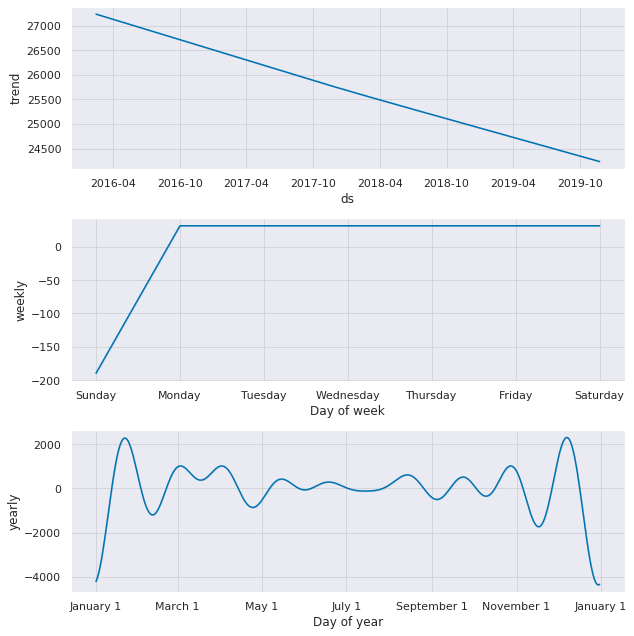

In [16]:
fig_decompose = m.plot_components(forecast)

In [17]:
compare_dates('2019-09-01', '2019-11-24', forecast, test)

,ds,y,yhat
0,2019-09-01,24632.04,23823.755966
1,2019-09-08,25638.09,23767.482962
2,2019-09-15,26020.79,24242.944705
3,2019-09-22,24193.45,24667.453012
4,2019-09-29,21979.14,24491.954577
5,2019-10-06,24833.23,23948.533264
6,2019-10-13,29091.20,23839.116814
7,2019-10-20,54784.86,24477.842502
8,2019-10-27,32441.04,25099.543959
9,2019-11-03,38829.11,24663.581268


# Fourier Model order 5

In [19]:
print(train.shape)
print(test.shape)
test

(184, 2)
(13, 2)


,ds,y
184,2019-09-01,24632.04
185,2019-09-08,25638.09
186,2019-09-15,26020.79
187,2019-09-22,24193.45
188,2019-09-29,21979.14
189,2019-10-06,24833.23
190,2019-10-13,29091.20
191,2019-10-20,54784.86
192,2019-10-27,32441.04
193,2019-11-03,38829.11


In [0]:
m1 = Prophet(
    weekly_seasonality=False, 
    daily_seasonality=False)
m1.add_seasonality(
    name='weekly', 
    period=5, 
    fourier_order=5)
m1.fit(train)
future1 = m1.make_future_dataframe(periods=13, freq='W')
forecast1 = m1.predict(future1)

In [21]:
compare_dates('2019-09-01', '2019-11-24', forecast1, test)

,ds,y,yhat
0,2019-09-01,24632.04,23520.964113
1,2019-09-08,25638.09,23656.580611
2,2019-09-15,26020.79,23289.877782
3,2019-09-22,24193.45,24933.360975
4,2019-09-29,21979.14,25415.502951
5,2019-10-06,24833.23,23758.299122
6,2019-10-13,29091.20,23761.359103
7,2019-10-20,54784.86,23488.971070
8,2019-10-27,32441.04,25329.341364
9,2019-11-03,38829.11,25594.928885


# With Holidays

In [24]:
print(train.shape)
print(test.shape)
test

(184, 2)
(13, 2)


,ds,y
184,2019-09-01,24632.04
185,2019-09-08,25638.09
186,2019-09-15,26020.79
187,2019-09-22,24193.45
188,2019-09-29,21979.14
189,2019-10-06,24833.23
190,2019-10-13,29091.20
191,2019-10-20,54784.86
192,2019-10-27,32441.04
193,2019-11-03,38829.11


In [0]:
df_holidays = get_df_holidays([2016,2017,2018,2019])
m2 = Prophet(holidays=df_holidays,daily_seasonality=True,weekly_seasonality=True)
m2.add_country_holidays(country_name='US')
m2.fit(train)
future2 = m2.make_future_dataframe(periods=13, freq='W')
forecast2 = m2.predict(future2)

# Normalized

In [0]:
y = train['y'].to_frame()
min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(y)
ds_scaled = train['ds'].to_frame()
dataset = pd.DataFrame({'y': y_scaled[:, 0]})
a = pd.concat([ds_scaled, dataset], axis=1)

In [0]:
m4 = Prophet(weekly_seasonality=False,daily_seasonality=False)
m4.fit(a)
future4 = m4.make_future_dataframe(periods=13, freq='w')
forecast4 = m4.predict(future4)

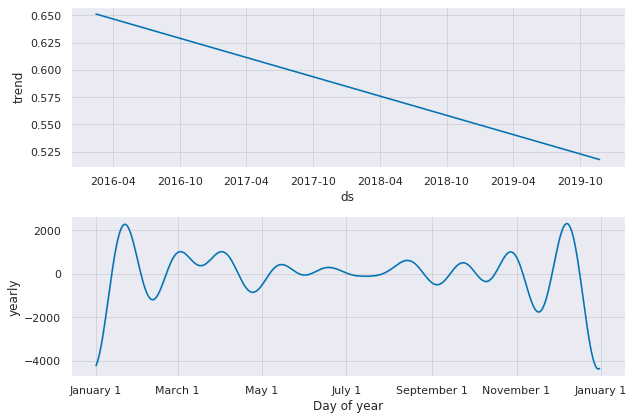

In [69]:
fig_decompose = m.plot_components(forecast4)

# Compare Models

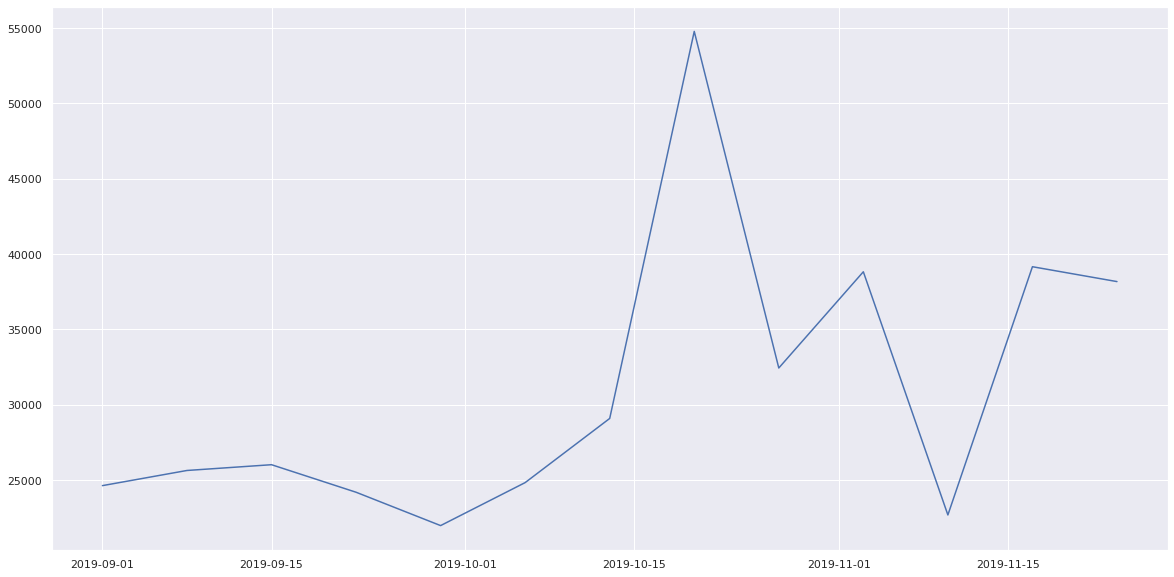

In [73]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(revenue_x_w[revenue_x_w['ds'] >= '2019-09-01']['ds'], revenue_x_w[revenue_x_w['ds'] >= '2019-09-01']['y'], label='y')

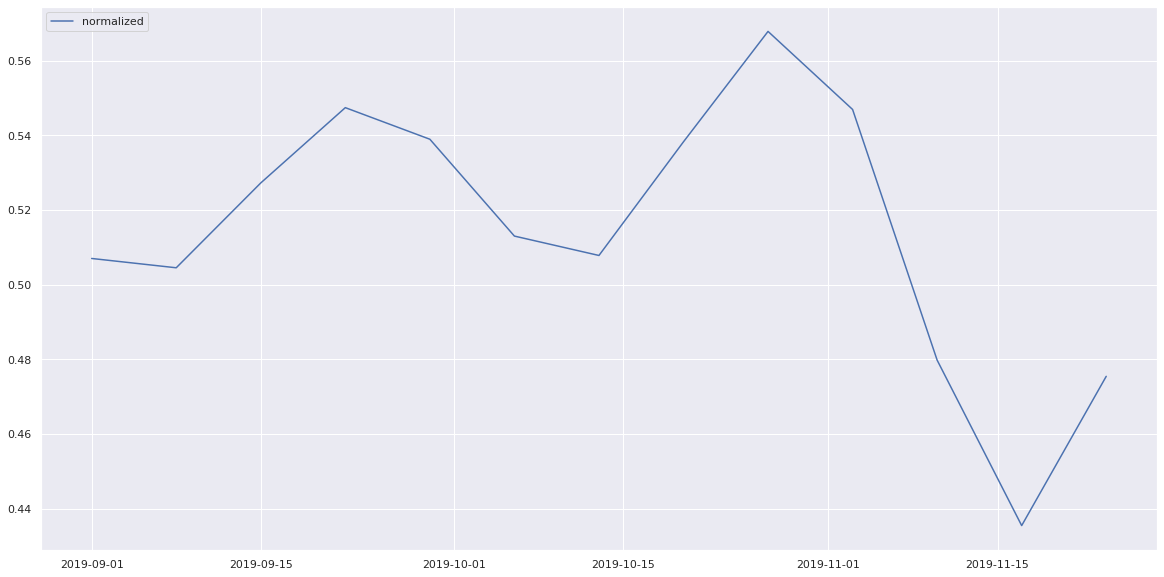

In [72]:
plt.rcParams["figure.figsize"] = (20,10)
#plt.plot(forecast[forecast['ds'] >= '2019-09-01']['ds'], forecast[forecast['ds'] >= '2019-09-01']['yhat'], label='forecast simple')
#plt.plot(forecast1[forecast1['ds'] >= '2019-09-01']['ds'], forecast1[forecast1['ds'] >= '2019-09-01']['yhat'], label='fourier 5')
#plt.plot(forecast2[forecast2['ds'] >= '2019-09-01']['ds'], forecast2[forecast2['ds'] >= '2019-09-01']['yhat'], label='holidays')
plt.plot(forecast4[forecast4['ds'] >= '2019-09-01']['ds'], forecast4[forecast4['ds'] >= '2019-09-01']['yhat'], label='normalized')
plt.legend(loc="upper left")